# 1.  Data analysis

In [76]:
import numpy as np
import pandas as pd
import os

In [2]:
# working direc
print(os.getcwd())

/Users/dongwook/Desktop/Project/Plant_Seeding


### 1.1 class analysis

In [3]:
predict_csv_path = './sample_submission.csv'
train_data_path = './plant-seedlings-classification/train/'
test_data_path = './plant-seedlings-classification/test/'

total_img=0
# class checking
for name in os.listdir(train_data_path):
    path, dirs, files = next(os.walk(train_data_path+'/'+name))
    file_count = len(files)
    print(f'{name} : {file_count}')
    total_img=total_img+file_count
print(f'number_of_total_img : {total_img}')

Cleavers : 287
Sugar beet : 385
Common Chickweed : 611
Loose Silky-bent : 654
Scentless Mayweed : 516
Shepherds Purse : 231
Fat Hen : 475
Common wheat : 221
Black-grass : 263
Small-flowered Cranesbill : 496
Charlock : 390
Maize : 221
number_of_total_img : 4750


### 1.2 Getting mean and std of Images for Normalization

In [4]:
import torchvision
import torch
#random seed = 10

torch.manual_seed(10)
dataset = torchvision.datasets.ImageFolder(train_data_path)
train_count = int(0.8*len(dataset))
valid_count = len(dataset)-train_count
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_count, valid_count])

In [29]:
def get_mean_std(dataset):
    meanRGB = [np.mean(np.array(image), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(np.array(image), axis=(1,2)) for image,_ in dataset]
    
    meanR = np.mean([round(m[0],3) for m in meanRGB])/255
    meanG = np.mean([round(m[1],3) for m in meanRGB])/255
    meanB = np.mean([round(m[2],3) for m in meanRGB])/255
    stdR = np.mean([round(s[0],3) for s in stdRGB])/255
    stdG = np.mean([round(s[1],3) for s in stdRGB])/255
    stdB = np.mean([round(s[2],3) for s in stdRGB])/255
    
    print(f' mean RGB : ({meanR}, {meanG}, {meanB})')
    print(f' std RGB : ({stdR}, {stdG}, {stdB})')
    
    return [meanR,meanG,meanB], [stdR,stdG,stdB]

In [30]:
# train / valid  mean,std value
train_meanRGB, train_stdRGB = get_mean_std(train_dataset)
valid_meanRGB, valid_stdRGB = get_mean_std(valid_dataset)

 mean RGB : (0.3008560392156863, 0.30039744994840045, 0.29999181836945293)
 std RGB : (0.10043112590299277, 0.10037887616099073, 0.10033660474716202)
 mean RGB : (0.30382733539731677, 0.30337900103199167, 0.30278192776057794)
 std RGB : (0.10033984313725491, 0.10004942414860682, 0.09992696388028896)


### 1.3 Image analysis(random img)

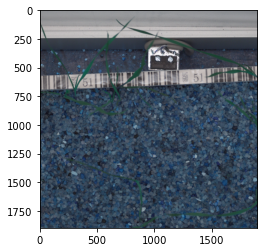

In [15]:
import PIL
import cv2
from matplotlib import pyplot as plt
path = './plant-seedlings-classification/train/Black-grass/0ace21089.png'
img = cv2.imread(path) 
plt.imshow(img)


In [75]:
import numpy as np
from torchvision import transforms
from PIL import Image

trans = transforms.Compose([
    transforms.ToTensor()
])

demo = Image.open('./plant-seedlings-classification/train/Black-grass/0ace21089.png') 
demo_img = trans(demo)

print(demo.size)
print(demo_img.size())


(1900, 1899)
torch.Size([3, 1899, 1900])


### 1.4 Model analysis

In [73]:
from torchsummary import summary
from torchvision import models
model = models.resnet50(pretrained=True)
model2 = models.vgg16(pretrained=True)
summary(model, (3, 480, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]           9,408
       BatchNorm2d-2         [-1, 64, 240, 240]             128
              ReLU-3         [-1, 64, 240, 240]               0
         MaxPool2d-4         [-1, 64, 120, 120]               0
            Conv2d-5         [-1, 64, 120, 120]           4,096
       BatchNorm2d-6         [-1, 64, 120, 120]             128
              ReLU-7         [-1, 64, 120, 120]               0
            Conv2d-8         [-1, 64, 120, 120]          36,864
       BatchNorm2d-9         [-1, 64, 120, 120]             128
             ReLU-10         [-1, 64, 120, 120]               0
           Conv2d-11        [-1, 256, 120, 120]          16,384
      BatchNorm2d-12        [-1, 256, 120, 120]             512
           Conv2d-13        [-1, 256, 120, 120]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [74]:
summary(model2, (3, 480, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 480, 480]           1,792
              ReLU-2         [-1, 64, 480, 480]               0
            Conv2d-3         [-1, 64, 480, 480]          36,928
              ReLU-4         [-1, 64, 480, 480]               0
         MaxPool2d-5         [-1, 64, 240, 240]               0
            Conv2d-6        [-1, 128, 240, 240]          73,856
              ReLU-7        [-1, 128, 240, 240]               0
            Conv2d-8        [-1, 128, 240, 240]         147,584
              ReLU-9        [-1, 128, 240, 240]               0
        MaxPool2d-10        [-1, 128, 120, 120]               0
           Conv2d-11        [-1, 256, 120, 120]         295,168
             ReLU-12        [-1, 256, 120, 120]               0
           Conv2d-13        [-1, 256, 120, 120]         590,080
             ReLU-14        [-1, 256, 1

In [ ]:
#pip install opencv-contrib-python

In [120]:
from skimage.data import camera
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [76]:
def create_mask_for_plant(image):
    sensitivity=35
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [87]:

def show_image_preprocc(image):
    image_mask = create_mask_for_plant(image)
    image_segmented = segment_plant(image)
    image_sharpen = sharpen_image(image_segmented)
    fig, axs = plt.subplots(1, 4, figsize=(20, 20))
    axs[0].imshow(image)
    axs[0].set_title('origin_img')
    axs[1].imshow(image_mask)
    axs[1].set_title('masked_img')
    axs[2].imshow(image_segmented)
    axs[2].set_title('segmented_img')
    axs[3].imshow(image_sharpen)
    axs[3].set_title('GaussianBlur_img')

1st picture: original
2nd image: mask, based on HSV filter to select green
3rd image: original image with mask applied
4th image: application of a Gaussian filter on the 3rd image
         --> we use this one
5th image: application of a Non-local Means filter on the 4th image
         --> it takes a lot of time and lowers the final score, so we won't use it

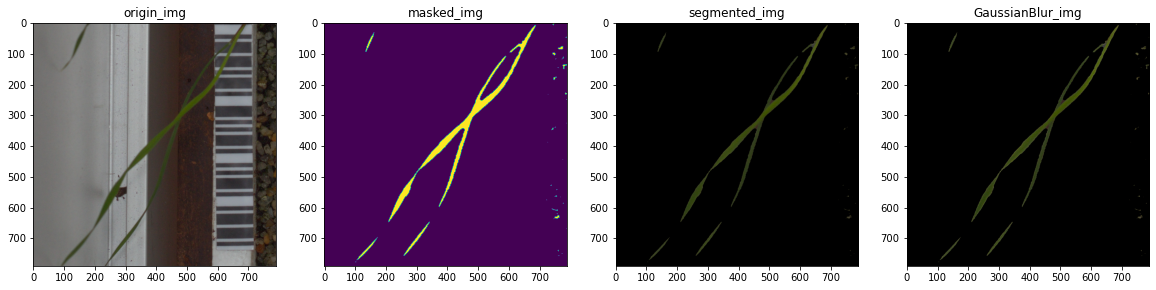

In [214]:
image_path = './Deep_Learning/plant-seedlings-classification/train/Black-grass/ab787fb46.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image_preprocc(image)

In [166]:
def delete_Background(image):
    image_segmented = segment_plant(image)
    image_sharpen = sharpen_image(image_segmented)

    return image_sharpen

In [167]:

img = cv2.imread('./Deep_Learning/plant-seedlings-classification/train/Black-grass/0260cffa8.png',cv2.IMREAD_COLOR)

    
def ORB(img, default):

    if default == None :
        orb = cv2.ORB_create()
    else : 
        orb = cv2.ORB_create(nfeatures=40000,
        scaleFactor=1.2,
        nlevels=8,
        edgeThreshold=31,
        firstLevel=0,
        WTA_K=2,
        scoreType=cv2.ORB_HARRIS_SCORE,
        patchSize=31,
        fastThreshold=20,)
    kps, des = orb.detectAndCompute(img, None)
#     img_rotated = cv2.warpAffine(img, H, (cols, rows))
#     kps_r, des_r = orb.detectAndCompute(img_rotated, None)
        

#     bf = cv2.BFMatcher_create()
#     matches = bf.knnMatch(des, des_r, k=2)

#     good = []
#     for m, n in matches:
#         if m.distance < 0.4 * n.distance:
#             good.append([m])

#     np.random.shuffle(good)
#     image_match = cv2.drawMatchesKnn(img, kps, img_rotated, kps_r, good[:10], flags=2, outImg=img)

    pts_x = [kp.pt[0] for kp in kps]
    pts_y = [kp.pt[1] for kp in kps]
    pts_s = [kp.size / 10 for kp in kps]


    plt.imshow(img, cmap='gray')
    plt.title("ORB keypoint")
    plt.axis("off")
    plt.scatter(pts_x, pts_y, s=pts_s, c="w")
    plt.show()
    return kps, des

In [178]:
import os
import numpy as np

train_dataset_path='./Traditional_method/plant-seedlings-classification/train/'
listdir = os.listdir(train_dataset_path)
listdir = [listdir for listdir in listdir if not listdir.startswith ('.')] #.DS_Store 제외



training_data = np.array([])
training_labels = np.array([])

for cl_name in listdir:
    imgdir = os.listdir(train_dataset_path+cl_name)
    for img_name in imgdir:
        
        img = cv2.imread(train_dataset_path+cl_name+imgdir, cv2.IMREAD_COLOR)
        
        #ORB
        _, des = ORB(delete_Background(img))
        
        #flatten_des
        vector_data = flatten_des(des)
        
        # making training data
        if len(training_data) == 0:
            training_data = np.append(training_data, vector_data)
            training_data = training_data.reshape(1,12800)
        else:
            training_data = np.concatenate((training_data, vector_data), axis=0)


        #labeling
        training_labels = np.append(training_labels,cl_name)

['Cleavers',
 'Sugar beet',
 'Common Chickweed',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Fat Hen',
 'Common wheat',
 'Black-grass',
 'Small-flowered Cranesbill',
 'Charlock',
 'Maize']

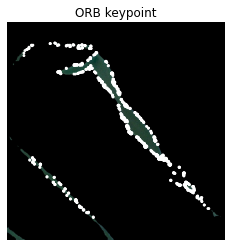

In [168]:
img = delete_Background(img)

kps, des = ORB(img, 1)

In [169]:
des.shape


(569, 32)

In [170]:
def flatten_des(des):
    des = des.astype(np.float64)
    print(des.shape)

    np.random.shuffle(des)
    des = des[0:100,:] # trim vector so all are same size
    print(des.shape)
    vector_data = des.reshape(1,des.shape[0]*des.shape[1]) 
    list_data = vector_data.tolist()

    
    return vector_data


(569, 32)
(100, 32)
(1, 3200)


In [182]:
train_dataset_path = './Traditional_method/plant-seedlings-classification/train/'

li = os.listdir(train_dataset_path)

li

['Cleavers',
 '.DS_Store',
 'Sugar beet',
 'Common Chickweed',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Fat Hen',
 'Common wheat',
 'Black-grass',
 'Small-flowered Cranesbill',
 'Charlock',
 'Maize']

In [196]:
a = None
b = 5

if(a is None):
    print("A is None")

A is None


In [199]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline


path = './Deep_Learning/plant-seedlings-classification/train/Black-grass/dca86daba.png'
# read images
img1 = cv2.imread(path)  

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)




In [209]:
path = './Deep_Learning/plant-seedlings-classification/train/Black-grass/dca86daba.png'
# read images
img1 = cv2.imread(path)  
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)


In [210]:
from skimage.io import imread, imshow

img = imread(path)

In [218]:
a=[[1,2],[2,3]]

for (i, img) in(a):
    print(i)
    print(img)

1
2
2
3


In [228]:
def SIFT(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kps, des = sift.detectAndCompute(img, None)

    return des
path = './Deep_Learning/plant-seedlings-classification/train/Black-grass/05eedce4d.png'
img1 = cv2.imread(path)  
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
des = SIFT(img1)

In [229]:
des.shape

(34, 128)

In [236]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
X, y = make_classification(n_samples=10, random_state=0)
X_train , X_test , y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_train)

(7, 20)
(7,)
[[-1.37495129  0.85683061 -0.80340966  1.56914464 -1.5447711  -0.35399391
  -0.68954978 -0.65102559 -0.4555325   0.68159452  0.92085882  2.38363567
  -1.03424284  1.46552373  0.31872765 -1.00021535  0.31694261  0.01747916
   1.18802979 -1.56101351]
 [-0.15501009  1.92294203 -0.86122569  0.99958558  0.96939671  0.94725197
   1.91006495  1.48051479 -0.26800337  0.90604466 -0.41361898 -0.98740462
   1.86755896 -0.0568887  -0.74745481 -1.270485    1.94362119  0.8024564
  -1.17312341  1.20960511]
 [-1.18063218 -0.50965218 -1.61389785  0.50054121 -0.30230275 -0.51080514
  -0.21274028 -0.4380743  -0.89546656  0.77749036 -1.70627019 -2.24080141
  -1.25279536 -0.7187573   1.9507754  -0.38732682 -1.42001794  0.3869025
  -1.04855297  2.14171734]
 [ 0.84436298  1.12663592 -0.49803245 -0.81753611  1.71334272 -1.22543552
   1.92953205 -1.07993151  0.94942081 -0.43782004 -0.09845252  0.6476239
  -1.14746865 -0.01669425 -0.66347829 -0.06824161 -0.82643854  0.08755124
  -0.74475482 -0.8486

In [243]:
!pip install cyvlfeat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:01:010m
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [96 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-3.9
      creating build/lib.macosx-10.9-x86_64-3.9/cyvlfeat
      copying cyvlfeat/_version.py -> build/lib.macosx-10.9-x86_64-3.9/cyvlfeat
      copying cyvlfeat/__init__.py -> build/lib.macosx-10.9-x86_64-3.9/cyvlfeat
      copying cyvlfeat/utils.py -> build/lib.macosx-10.9-x86_64-3.9/cyvlfeat
      copying cyvlfeat/_static_version.py -> build/lib.macosx-10.9-x86_64-3.9/cyvlfeat
      creating build/lib.macosx-10.9-x86_64-3.9/cyvlfeat/vlad
      copying cyvlfeat/vlad/__init__.py -> build/lib.macosx-10.9-x86_64-3.9/cyvlfeat/vlad
      copying cyvlfeat/vlad/vlad.py -> build/

In [240]:
!conda config --show channels

channels:
  - defaults


In [247]:
image_desctiptors = [[1,2],[1,3]]

all_descriptors = []
for descriptor in image_desctiptors:
    if descriptor is not None:
        for des in descriptor:
            all_descriptors.append(des)
            
print(all_descriptors)

[1, 2, 1, 3]


In [253]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)
X.shape

(1000, 12)

In [256]:
a=np.array([1,2])
print(a)
a.resize((2,2))

print(a)

[1 2]
[[1 2]
 [0 0]]
